# Generate ML data using MOM6

### Setup dask

In [1]:
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))

flag_shut = False 

if flag_shut: 
    if len(open_clusters)>0:
        for c in open_clusters:
            cluster = gateway.connect(c.name)
            cluster.shutdown()  

options = gateway.cluster_options()

#options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
# options.worker_cores = 8

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.adapt(15, 40)
#cluster.scale(10)
client

[ClusterReport<name=prod.8a940c40d3c24388bcb0f1916ef8457c, status=RUNNING>, ClusterReport<name=prod.27fc0524808f462582eb8d1db0c9c588, status=RUNNING>]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.7c5dca228010479ebc1daeac7d26d6f5/status,


In [2]:
# If wanting to look at local server.
#import dask
#import distributed

#client = distributed.Client()
#client

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

In [4]:
from dask.diagnostics import ProgressBar

In [5]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [6]:
import gcsfs
fs = gcsfs.GCSFileSystem()
fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Double_Gyre/res5km')

['leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_0km_8_Aug_24.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_100km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_200km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_400km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_50km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_50km_8_Aug_24.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/prog.zarr']

In [6]:
#fs.rm(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/ml_data_0km_8_Aug_24.zarr', recursive=True)

In [7]:
#ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day/prog.zarr')
#ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge60day/prog.zarr')
#ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge300day/prog.zarr')

ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Double_Gyre/res5km/prog.zarr')

In [8]:
#Lfilter = np.array([400e3])
# These scales are slightly hacky because we are not treating the curved grids properly. 
Lfilter = int(200e3/5e3) #np.array([100e3/5e3], dtype=int) # 10=50km, 20=100km, 40=200km, 
#Lfilter = np.array([0.5])
#dx = 1/20
coarsen_factor = 5 
coarsen_points= int(Lfilter/coarsen_factor)#(Lfilter/coarsen_factor/dx).astype('int')

Lfilter, coarsen_points

(40, 8)

In [9]:
## Create grid area element 
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'},
            'Z': {'center': 'zl', 'outer': 'zi'} }

grid = Grid(ds, coords=coords, periodic=False)

dx = 110e3* grid.diff(ds.xq,'X', boundary='extend') * np.cos(ds.yh*np.pi/180)
dy = 110e3* grid.diff(ds.yq,'Y', boundary='extend')
area_t = dy*dx

In [10]:
def filter_dataset(ds): 

    ## parameters
    h_min = 20 #m
    dx_min = 1
    filter_scale = Lfilter # lat/lon points

    ## Make masks
    
    # make wet mask for layer thickness
    wet_mask_h = (ds.h>h_min).astype('float32').rename('wet_mask')
    # Add edges to domain
    wet_mask_h = wet_mask_h.where(ds.yh>=30.03, other=0)
    wet_mask_h = wet_mask_h.where(ds.xh>=0.03, other=0)

    # Make wet mask for interface points, by taking the mask for the layer below.
    wet_mask_e = wet_mask_h.copy()
    wet_mask_e = wet_mask_e.rename({'zl': 'zi'}).drop_vars('zi')
    #zeros_array = xr.DataArray(np.zeros((wet_mask_e.sizes['Time'], 1, wet_mask_e.sizes['yh'], wet_mask_e.sizes['xh'])),
    #                           dims=('Time', 'zi', 'yh', 'xh'))
    zeros_array = xr.DataArray(np.zeros((wet_mask_e.sizes['Time'], 1, wet_mask_e.sizes['yh'], wet_mask_e.sizes['xh'])),
                               dims=('Time','zi', 'yh', 'xh'))
    wet_mask_e = xr.concat([wet_mask_e, zeros_array], dim='zi').chunk({'zi':-1, 'xh':-1,'yh':-1})

    # make wet masks for interface but on zl points
    wet_mask_e_up = xr.DataArray(wet_mask_e.isel(zi=slice(0, -1)).data, 
                         dims=['Time','zl','yh','xh'])
    wet_mask_e_down = xr.DataArray(wet_mask_e.isel(zi=slice(1, None)).data, 
                         dims=['Time','zl','yh','xh'])


    filter_C_up = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_e_up})

    filter_C_down = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_e_down})

    filter_C_e = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_e})

    ## Filter

    # Center velocities
    u_c = grid.interp(ds.u.fillna(0), 'X', boundary='extend')
    v_c = grid.interp(ds.v.fillna(0), 'Y', boundary='extend')

    # Bring interface values to zl, so they can be operated on with velocities
    e_up = xr.DataArray(ds.e.isel(zi=slice(0, -1)).data, 
                         dims=['Time','zl','yh','xh'])
    e_down = xr.DataArray(ds.e.isel(zi=slice(1, None)).data, 
                         dims=['Time','zl','yh','xh'])

    ebar_up = filter_C_up.apply(e_up, dims=['yh','xh'])
    ebar_down = filter_C_down.apply(e_down, dims=['yh','xh'])
    
    hbar = ebar_up - ebar_down 

    ebar = filter_C_e.apply(ds.e, dims=['yh','xh'])
    
    # u component
    ue_bar_up = filter_C_up.apply(u_c * e_up, dims=['yh','xh'])
    ue_bar_down = filter_C_down.apply(u_c * e_down, dims=['yh','xh'])

    ubar_up = filter_C_up.apply(u_c, dims=['yh','xh'])
    ubar_down = filter_C_down.apply(u_c, dims=['yh','xh'])
    ubar = ubar_up # mask for upper interface is same as that for a layer (if layer vanishes then interface is grounded).
    
    ubar_up_ebar_up =   ubar_up * ebar_up
    ubar_down_ebar_down =   ubar_down * ebar_down

    uh_bar = ue_bar_up - ue_bar_down
    ubar_hbar = ubar_up_ebar_up - ubar_down_ebar_down 

    uphp = uh_bar - ubar_hbar

    # v component
    ve_bar_up = filter_C_up.apply(v_c * e_up, dims=['yh','xh'])
    ve_bar_down = filter_C_down.apply(v_c * e_down, dims=['yh','xh'])

    vbar_up = filter_C_up.apply(v_c, dims=['yh','xh'])
    vbar_down = filter_C_down.apply(v_c, dims=['yh','xh'])
    vbar = vbar_up
    
    vbar_up_ebar_up = vbar_up * ebar_up
    vbar_down_ebar_down = vbar_down * ebar_down

    vh_bar = ve_bar_up - ve_bar_down
    vbar_hbar = vbar_up_ebar_up - vbar_down_ebar_down 

    vphp = vh_bar - vbar_hbar

    # Add ubar, vbar, hbar, ebar, uphp, vphp to a dataset
    ds_filt = xr.Dataset(coords=ds.coords)
    ds_filt['ubar'] = ubar
    ds_filt['vbar'] = vbar
    ds_filt['hbar'] = hbar
    ds_filt['ebar'] = ebar
    ds_filt['uphp'] = uphp
    ds_filt['vphp'] = vphp
    
    return ds_filt


def add_gradients(ds_filt): 
    ds_filt['dudx'] = grid.interp(grid.diff(ds_filt.ubar, 'X'), 'X')/dx
    ds_filt['dvdx'] = grid.interp(grid.diff(ds_filt.vbar, 'X'), 'X')/dx
    ds_filt['dudy'] = grid.interp(grid.diff(ds_filt.ubar, 'Y'), 'Y')/dy
    ds_filt['dvdy'] = grid.interp(grid.diff(ds_filt.vbar, 'Y'), 'Y')/dy
    
    ds_filt['dedx'] = grid.interp(grid.diff(ds_filt.ebar, 'X'), 'X')/dx
    ds_filt['dedy'] = grid.interp(grid.diff(ds_filt.ebar, 'Y'), 'Y')/dy

    ds_filt['dhdx'] = grid.interp(grid.diff(ds_filt.hbar, 'X'), 'X')/dx
    ds_filt['dhdy'] = grid.interp(grid.diff(ds_filt.hbar, 'Y'), 'Y')/dy

    return ds_filt

def coarsen_dataset(ds, coarsen_points): 
    print('coarsening')
    return ds.coarsen(xh=coarsen_points, yh=coarsen_points, boundary='trim').mean()

In [11]:
# def filter_dataset(ds, Lfilter): 
    
#     #dx = ds.xh.diff('xh')[0].values*1e3
#     wet_mask= (ds.h.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
    
#     filter_C = gcmf.Filter(filter_scale= Lfilter,  
#                      dx_min = dx, 
#                      filter_shape=gcmf.FilterShape.GAUSSIAN,
#                      grid_type=gcmf.GridType.REGULAR_WITH_LAND,
#                      grid_vars = {'wet_mask': wet_mask})
    
#     xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
#                          'Y': {'center': 'yh', 'outer': 'yq'},
#                          'Z': {'center': 'zl', 'outer': 'zi'} },
#              periodic=['X'])
    
#     ds_filt = xr.Dataset() # For storing the filtered data 
#     print('Started')
#     ds_filt['h'] = filter_C.apply(ds.h, dims=['yh','xh']).rename('h')
    
#     u_c = xgrid.interp(ds.u.fillna(0), 'X')
#     v_c = xgrid.interp(ds.v.fillna(0), 'Y')
#     ds_filt['u'] = filter_C.apply(u_c, dims=['yh','xh']).rename('u')
#     ds_filt['v'] = filter_C.apply(v_c, dims=['yh','xh']).rename('v')
    
#     print('Filtered fields computed')
    
#     ds_filt['uh'] = ds.h*u_c
#     ds_filt['vh'] = ds.h*v_c
    
#     ds_filt['uu'] = u_c*u_c
#     ds_filt['vv'] = v_c*v_c
    
#     ds_filt['uh_bar'] = filter_C.apply(ds_filt['uh'], dims=['yh','xh']).rename('uh_bar')
#     ds_filt['vh_bar'] = filter_C.apply(ds_filt['vh'], dims=['yh','xh']).rename('vh_bar')
    
#     ds_filt['uu_bar'] = filter_C.apply(ds_filt['uu'], dims=['yh','xh']).rename('uu_bar')
#     ds_filt['vv_bar'] = filter_C.apply(ds_filt['vv'], dims=['yh','xh']).rename('vv_bar')
    
#     ds_filt['ubar_hbar'] = (ds_filt.h*ds_filt.u)
#     ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)
    
#     ds_filt['ubar_ubar'] = (ds_filt.u*ds_filt.u)
#     ds_filt['vbar_vbar'] = (ds_filt.v*ds_filt.v)
    
#     ds_filt['uh_sg'] = ds_filt['uh_bar'] - ds_filt['ubar_hbar']
#     ds_filt['vh_sg'] = ds_filt['vh_bar'] - ds_filt['vbar_hbar']
    
#     ds_filt['uu_sg'] = ds_filt['uu_bar'] - ds_filt['ubar_ubar']
#     ds_filt['vv_sg'] = ds_filt['vv_bar'] - ds_filt['vbar_vbar']

#     ## Interface method (for topography)
#     # Needs to be modified for more than 2 layers
#     ds_filt['v2e1'] = ds.e.isel(zi=1)*v_c.isel(zl=1)
#     ds_filt['v2e1_bar'] = filter_C.apply(ds_filt['v2e1'], dims=['yh','xh']).rename('v2e1_bar')
#     ds_filt['v2bar_e1bar'] = (ds_filt.e.isel(zi=1)*ds_filt.v.isel(zl=1))
#     ds_filt['v2e1_sg'] = ds_filt['v2e1_bar'] - ds_filt['v2bar_e1bar']

#     ds_filt['u2e1'] = ds.e.isel(zi=1)*u_c.isel(zl=1)
#     ds_filt['u2e1_bar'] = filter_C.apply(ds_filt['u2e1'], dims=['yh','xh']).rename('u2e1_bar')
#     ds_filt['u2bar_e1bar'] = (ds_filt.e.isel(zi=1)*ds_filt.u.isel(zl=1))
#     ds_filt['u2e1_sg'] = ds_filt['u2e1_bar'] - ds_filt['u2bar_e1bar']
    

    
#     print('Fluxes computed')
    
#     ds_filt['dudx'] = xgrid.interp(xgrid.diff(ds_filt.u, 'X')/dx, 'X')
#     ds_filt['dvdx'] = xgrid.interp(xgrid.diff(ds_filt.v, 'X')/dx, 'X')
#     ds_filt['dudy'] = xgrid.interp(xgrid.diff(ds_filt.u, 'Y')/dx, 'Y')
#     ds_filt['dvdy'] = xgrid.interp(xgrid.diff(ds_filt.v, 'Y')/dx, 'Y')
#     ds_filt['slope_x'] = xgrid.interp(xgrid.diff(ds_filt.e, 'X')/dx, 'X')
#     ds_filt['slope_y'] = xgrid.interp(xgrid.diff(ds_filt.e, 'Y')/dx, 'Y')
    
#     print('Gradients computed')
    
#     return ds_filt

In [11]:
ds_filt  = add_gradients(filter_dataset(ds))

In [12]:
ds_filt_coarsen = coarsen_dataset(ds_filt, coarsen_points) 

coarsening


In [13]:
ds_filt_coarsen = ds_filt_coarsen.drop(['xq', 'yq']).chunk({'Time':36, 'xh':-1,'yh':-1,'zl':-1,'zi':-1})

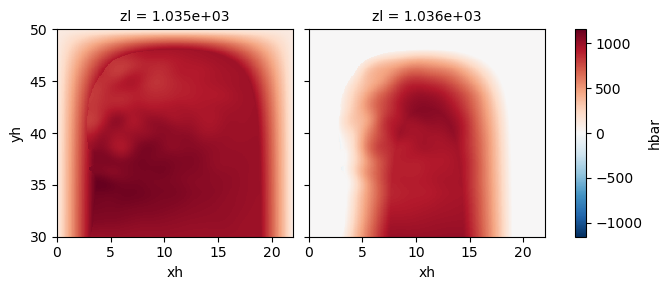

In [14]:
ds_filt.hbar.isel(Time=-1).plot(col='zl')

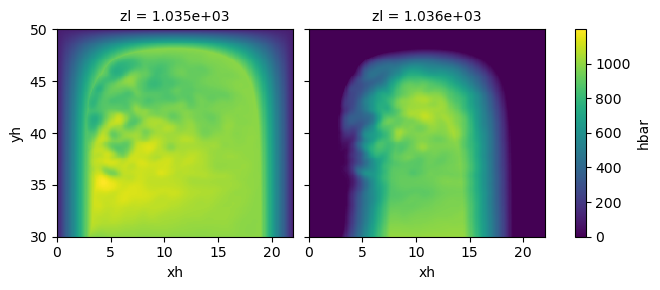

In [18]:
ds_filt_coarsen.hbar.isel(Time=-1).plot(col='zl')

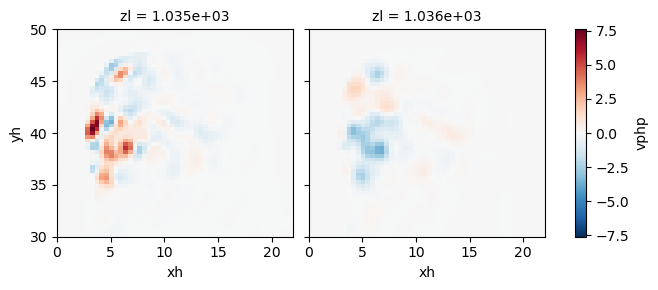

In [15]:
ds_filt_coarsen.vphp.isel(Time=-1).plot(col='zl')

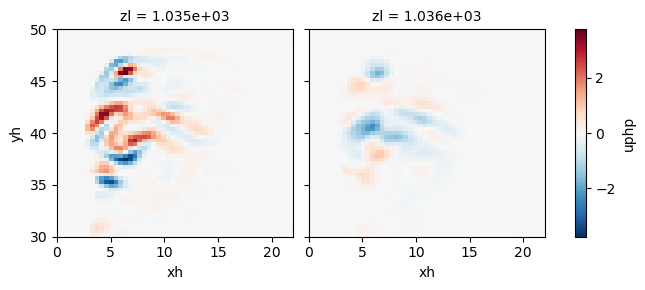

In [16]:
ds_filt_coarsen.uphp.isel(Time=-1).plot(col='zl')

In [17]:
#ds_filt_coarsen_small = ds_filt_coarsen.isel(Time=slice(0, 1440))

In [18]:
#with ProgressBar():
#    ds_filt_coarsen_small.load()

In [19]:
fname = f'{PERSISTENT_BUCKET}/MOM6/Double_Gyre/res5km/ml_data_'+str(int(Lfilter*5e3/1e3))+'km_8_Aug_24.zarr'
#fname = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_'+str(int(Lfilter/1e3))+'km.zarr'
fname
mapper = fs.get_mapper(fname)

In [20]:
fname

'gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_200km_8_Aug_24.zarr'

In [21]:
def to_zarr_split(ds, mapper, split_dim="time", split_interval=1):
    print(f"Writing to {mapper.root} ...")

    n = len(ds[split_dim])
    splits = list(range(0, n, split_interval))

    # Make sure the last item in the list covers the full length
    # of the time on our dataset
    if splits[-1] != n:
        splits = splits + [n]

    split_datasets = []
    for ii in range(len(splits) - 1):
        start = splits[ii]
        stop = splits[ii + 1]
        split_datasets.append(ds.isel({split_dim: slice(start, stop)}))

    # write the first array
    # TODO: move the first write to the loop so it is counted in the viz bar
    split_datasets[0].to_zarr(mapper)
    for ds_split in tqdm(split_datasets[1:None]):
        ds_split.to_zarr(mapper, append_dim=split_dim)

    # overwrite the split dimension as single chunk (this should reproduce
    # what xr.to_zarr would do
    g = zarr.open_group(mapper)
    del g[split_dim]
    
    ds[[split_dim]].load().to_zarr(mapper, mode='a')
    zarr.consolidate_metadata(mapper)

In [22]:
import zarr
from tqdm.auto import tqdm

In [ ]:
%%time 
to_zarr_split(ds_filt_coarsen, mapper, split_dim='Time', split_interval=720)

Writing to leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_200km_8_Aug_24.zarr ...


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#fname = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day/ml_data_'+str(int(Lfilter/1e3))+'km.zarr'
#fname = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge60day/ml_data_'+str(int(Lfilter/1e3))+'km.zarr'
#fname = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge300day/ml_data_'+str(int(Lfilter/1e3))+'km.zarr'


In [24]:
fname

'gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_200km_8_Aug_24.zarr'

In [25]:
test = xr.open_zarr(fname)

In [26]:
test

<xarray.Dataset> Size: 2GB
Dimensions:  (Time: 3600, zi: 3, yh: 55, xh: 50, zl: 2)
Coordinates:
  * Time     (Time) object 29kB 0001-01-11 00:00:00 ... 0099-07-26 00:00:00
  * xh       (xh) float64 400B 0.22 0.66 1.1 1.54 ... 20.46 20.9 21.34 21.78
  * yh       (yh) float64 440B 30.18 30.55 30.91 31.27 ... 49.09 49.45 49.82
  * zi       (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
Data variables: (12/14)
    dedx     (Time, zi, yh, xh) float64 238MB dask.array<chunksize=(36, 3, 55, 50), meta=np.ndarray>
    dedy     (Time, zi, yh, xh) float64 238MB dask.array<chunksize=(36, 3, 55, 50), meta=np.ndarray>
    dhdx     (Time, zl, yh, xh) float64 158MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>
    dhdy     (Time, zl, yh, xh) float64 158MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>
    dudx     (Time, zl, yh, xh) float64 158MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>
    dudy     (Time, zl, yh, xh) float64 158MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>
    ...       ...
    ebar     (Time, zi, yh, xh) float32 119MB dask.array<chunksize=(36, 3, 55, 50), meta=np.ndarray>
    hbar     (Time, zl, yh, xh) float32 79MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>
    ubar     (Time, zl, yh, xh) float32 79MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>
    uphp     (Time, zl, yh, xh) float32 79MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>
    vbar     (Time, zl, yh, xh) float32 79MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>
    vphp     (Time, zl, yh, xh) float32 79MB dask.array<chunksize=(36, 2, 55, 50), meta=np.ndarray>

In [ ]:
#fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge300day/')

### When done

In [27]:
cluster.shutdown()